In [1]:
import multiprocessing
from multiprocessing import Pool
import threading
import vio_ort
import vio_ort2
import json
import matplotlib.pyplot as plt # type: ignore
import os
import cv2 # type: ignore
import numpy as np # type: ignore

In [2]:
odometry = vio_ort2.VIO(lat0=54.889668, lon0=83.1258973333, alt0=0)

# Путь к папке
#set_dir = '2025_1_16_15_43_35'
#set_dir = '2024_12_15_15_18_8_num_24'
set_dir = '2024_12_15_15_31_8_num_3'
#set_dir = '2024_12_15_15_31_8_num_5'

# Получение всех файлов с расширением .json
json_files = [f for f in os.listdir(set_dir) if f.endswith('.json')]

# Сортировка файлов по имени
json_files.sort()

# start_json = "1730798575417.json"
start = 30
count_json = 600

lat_VIO = []
lon_VIO = []

lat_GPS = []
lon_GPS = []

Использование multiprocessing

In [3]:
def process_file(filename):
    with open(f'{set_dir}/{filename}', 'r') as file:
        data = json.load(file)
        if 'GNRMC' in data and data['GNRMC']['status'] == 'A':
            img_path = f'{set_dir}/{os.path.splitext(filename)[0]}.jpg'
            
            if not os.path.exists(img_path):
                return None
            
            image = cv2.imread(img_path)
            if image is None:
                return None
            
            try:
                result_vio = odometry.add_trace_pt(image, data)
                return dict(
                    lat_VIO=result_vio['lat'],
                    lon_VIO=result_vio['lon'],
                    lat_GPS=data['GNRMC']['lat'],
                    lon_GPS=data['GNRMC']['lon'],
                    elapsed_time=result_vio['elapsed_time'],
                    timings=result_vio['timings']
                )
            except Exception as e:
                print(f"Error processing {filename}: {e}")
                return None

# Используем multiprocessing
with Pool(processes=multiprocessing.cpu_count()) as pool:
    results = pool.map(process_file, json_files[start:start + count_json])

# Распаковываем результаты
elapsed_times = []
all_timings = []
lat_VIO = []
lon_VIO = []
lat_GPS = []
lon_GPS = []

for result in results:
    if result:
        elapsed_times.append(result['elapsed_time'])
        all_timings.append(result['timings'])
        lat_VIO.append(result['lat_VIO'])
        lon_VIO.append(result['lon_VIO'])
        lat_GPS.append(result['lat_GPS'])
        lon_GPS.append(result['lon_GPS'])


Список времени выполнения: 39.7s, 39.3s, 39.2s

In [4]:
print(f"Среднее время обработки одного файла: {np.mean(elapsed_times):.4f} секунд")
print(f"Максимальное время обработки: {np.max(elapsed_times):.4f} секунд")
print(f"Минимальное время обработки: {np.min(elapsed_times):.4f} секунд")

Среднее время обработки одного файла: 1.0978 секунд
Максимальное время обработки: 2.0564 секунд
Минимальное время обработки: 0.0612 секунд


In [5]:
# Анализ времени этапов
average_timings = {key: np.mean([t[key] for t in all_timings]) for key in all_timings[0].keys()}
print("Среднее время по этапам:")
for key, value in average_timings.items():
    print(f"{key}: {value:.10f} секунд")

Среднее время по этапам:
fetch_angles: 0.0000029390 секунд
fetch_height: 0.0000255847 секунд
preprocess_frame: 0.0069884689 секунд
rotation: 0.0131157041 секунд
fisheye_correction: 0.0291237697 секунд
detect_and_compute: 0.9401519339 секунд
local_position_calculation: 0.1083272274 секунд
velocity_calculation: 0.0000206895 секунд
GPS_calculation: 0.0000429427 секунд


Использование батч

In [6]:
batch_size = 20

def process_batch(file_batch):
    batch_results = []
    for filename in file_batch:
        result = process_file(filename)
        if result:
            batch_results.append(result)
    return batch_results

# Разделяем файлы на батчи
batches = [json_files[i:i + batch_size] for i in range(start, start + count_json, batch_size)]

with Pool(processes=multiprocessing.cpu_count()) as pool:
    all_batch_results = pool.map(process_batch, batches)

# Собираем результаты
for batch_results in all_batch_results:
    for result in batch_results:
        elapsed_times.append(result['elapsed_time'])
        all_timings.append(result['timings'])
        lat_VIO.append(result['lat_VIO'])
        lon_VIO.append(result['lon_VIO'])
        lat_GPS.append(result['lat_GPS'])
        lon_GPS.append(result['lon_GPS'])


Список времени выполнения: 38.8s, 38.7s, 37.8s

In [7]:
print(f"Среднее время обработки одного файла: {np.mean(elapsed_times):.4f} секунд")
print(f"Максимальное время обработки: {np.max(elapsed_times):.4f} секунд")
print(f"Минимальное время обработки: {np.min(elapsed_times):.4f} секунд")

Среднее время обработки одного файла: 1.0564 секунд
Максимальное время обработки: 2.0564 секунд
Минимальное время обработки: 0.0473 секунд


In [8]:
# Анализ времени этапов
average_timings = {key: np.mean([t[key] for t in all_timings]) for key in all_timings[0].keys()}
print("Среднее время по этапам:")
for key, value in average_timings.items():
    print(f"{key}: {value:.10f} секунд")

Среднее время по этапам:
fetch_angles: 0.0000066865 секунд
fetch_height: 0.0000144611 секунд
preprocess_frame: 0.0066763954 секунд
rotation: 0.0127883860 секунд
fisheye_correction: 0.0282012798 секунд
detect_and_compute: 0.9050458141 секунд
local_position_calculation: 0.1035474700 секунд
velocity_calculation: 0.0000203866 секунд
GPS_calculation: 0.0000415680 секунд


Использование asyncio

In [9]:
import aiofiles
from aiohttp import ClientSession
import asyncio
import nest_asyncio
nest_asyncio.apply()

async def process_file_async(filename):
    async with aiofiles.open(f'{set_dir}/{filename}', 'r') as file:
        data = json.loads(await file.read())
        if 'GNRMC' in data and data['GNRMC']['status'] == 'A':
            img_path = f'{set_dir}/{os.path.splitext(filename)[0]}.jpg'
            
            if not os.path.exists(img_path):
                return None
            
            image = cv2.imread(img_path)
            if image is None:
                return None
            
            try:
                result_vio = odometry.add_trace_pt(image, data)
                return dict(
                    lat_VIO=result_vio['lat'],
                    lon_VIO=result_vio['lon'],
                    lat_GPS=data['GNRMC']['lat'],
                    lon_GPS=data['GNRMC']['lon'],
                    elapsed_time=result_vio['elapsed_time'],
                    timings=result_vio['timings']
                )
            except Exception as e:
                print(f"Error processing {filename}: {e}")
                return None

async def main():
    tasks = [process_file_async(filename) for filename in json_files[start:start + count_json]]
    results = await asyncio.gather(*tasks)
    return results

results = asyncio.get_event_loop().run_until_complete(main())
# Распаковка результатов
elapsed_times = []
all_timings = []
lat_VIO = []
lon_VIO = []
lat_GPS = []
lon_GPS = []

for result in results:
    if result:
        elapsed_times.append(result['elapsed_time'])
        all_timings.append(result['timings'])
        lat_VIO.append(result['lat_VIO'])
        lon_VIO.append(result['lon_VIO'])
        lat_GPS.append(result['lat_GPS'])
        lon_GPS.append(result['lon_GPS'])

Список времени выполнения: 34.9s, 34.6s, 33.7s

In [10]:
print(f"Среднее время обработки одного файла: {np.mean(elapsed_times):.4f} секунд")
print(f"Максимальное время обработки: {np.max(elapsed_times):.4f} секунд")
print(f"Минимальное время обработки: {np.min(elapsed_times):.4f} секунд")

Среднее время обработки одного файла: 0.0605 секунд
Максимальное время обработки: 0.0956 секунд
Минимальное время обработки: 0.0454 секунд


In [11]:
# Анализ времени этапов
average_timings = {key: np.mean([t[key] for t in all_timings]) for key in all_timings[0].keys()}
print("Среднее время по этапам:")
for key, value in average_timings.items():
    print(f"{key}: {value:.10f} секунд")

Среднее время по этапам:
fetch_angles: 0.0000022932 секунд
fetch_height: 0.0000029677 секунд
preprocess_frame: 0.0009194514 секунд
rotation: 0.0010184556 секунд
fisheye_correction: 0.0053864386 секунд
detect_and_compute: 0.0439492182 секунд
local_position_calculation: 0.0091991295 секунд
velocity_calculation: 0.0000212148 секунд
GPS_calculation: 0.0000407257 секунд


Использование threading

In [12]:
# Код с потоковой оптимизацией
def process_file_threaded(filename):
    with open(f'{set_dir}/{filename}', 'r') as file:
        data = json.load(file)
        if 'GNRMC' in data and data['GNRMC']['status'] == 'A':
            img_path = f'{set_dir}/{os.path.splitext(filename)[0]}.jpg'
            
            if not os.path.exists(img_path):
                return
            
            image = cv2.imread(img_path)
            if image is None:
                return
            
            try:
                result_vio = odometry.add_trace_pt(image, data)
                with threading.Lock():
                    lat_VIO.append(result_vio['lat'])
                    lon_VIO.append(result_vio['lon'])
                    lat_GPS.append(data['GNRMC']['lat'])
                    lon_GPS.append(data['GNRMC']['lon'])
                    # собираем время
                    elapsed_times.append(result_vio['elapsed_time'])
                    # собираем этапы
                    all_timings.append(result_vio['timings'])
            except Exception as e:
                print(f"Error processing {filename}: {e}")

# Запускаем обработку в потоках
threads = []
elapsed_times = []
all_timings = []
for filename in json_files[start:start + count_json]:
    thread = threading.Thread(target=process_file_threaded, args=(filename,))
    threads.append(thread)
    thread.start()

for thread in threads:
    thread.join()

Список времени выполнения: 13.6s, 12.8s, 13.1s

In [13]:
print(f"Среднее время обработки одного файла: {np.mean(elapsed_times):.4f} секунд")
print(f"Максимальное время обработки: {np.max(elapsed_times):.4f} секунд")
print(f"Минимальное время обработки: {np.min(elapsed_times):.4f} секунд")

Среднее время обработки одного файла: 5.9665 секунд
Максимальное время обработки: 13.0228 секунд
Минимальное время обработки: 0.6203 секунд


In [14]:
# Анализ времени этапов
average_timings = {key: np.mean([t[key] for t in all_timings]) for key in all_timings[0].keys()}
print("Среднее время по этапам:")
for key, value in average_timings.items():
    print(f"{key}: {value:.10f} секунд")

Среднее время по этапам:
fetch_angles: 0.0000042525 секунд
fetch_height: 0.0000042965 секунд
preprocess_frame: 0.0108856631 секунд
rotation: 0.0268887116 секунд
fisheye_correction: 0.1505293954 секунд
detect_and_compute: 0.7037127695 секунд
local_position_calculation: 5.0744109714 секунд
velocity_calculation: 0.0000219690 секунд
GPS_calculation: 0.0000425730 секунд


In [15]:
print(f'GPS lat: {lat_GPS[0]}')
print(f'VIO lat: {lat_VIO[0]}')

GPS lat: 54.8894115
VIO lat: 54.889667990859635


In [16]:
print(f'GPS lon: {lon_GPS[0]}')
print(f'VIO lon: {lon_VIO[0]}')

GPS lon: 83.1257321667
VIO lon: 83.12589734620471


In [17]:
print(len(lat_GPS))
print(len(lat_VIO))

1064
1064


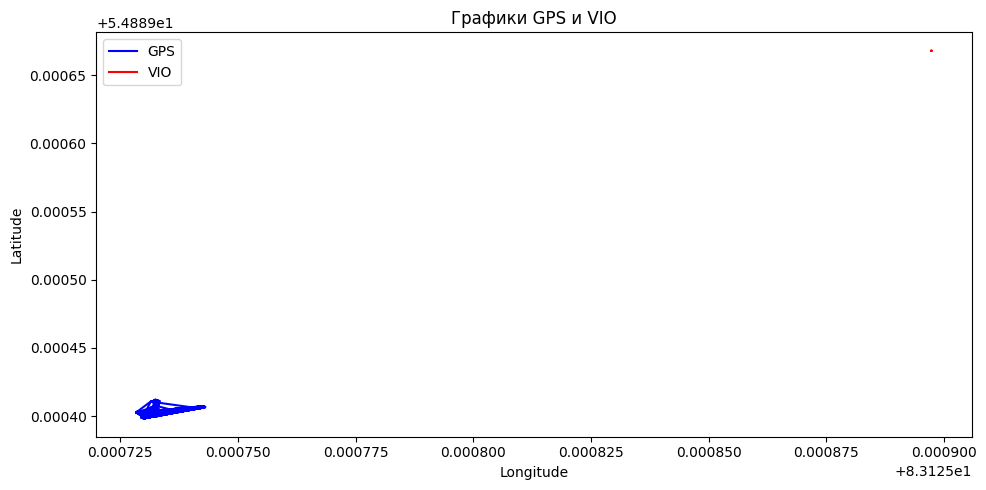

In [18]:
copy_lat_VIO = lat_VIO.copy()
copy_lon_VIO = lon_VIO.copy()

copy_lat_GPS = lat_GPS.copy()
copy_lon_GPS = lon_GPS.copy()

# Create figure and axis
# Создаем фигуру и оси
plt.figure(figsize=(10, 5))
copy_lat_GPS = [ - x + 2 * 54.8894116667 for x in copy_lat_GPS]

# Рисуем первый график
plt.plot(copy_lon_GPS, copy_lat_GPS, label='GPS', color='blue')

# Рисуем второй график
plt.plot(copy_lon_VIO, copy_lat_VIO, label='VIO', color='red')

# Добавляем заголовок и метки осей
plt.title('Графики GPS и VIO')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Добавляем легенду
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

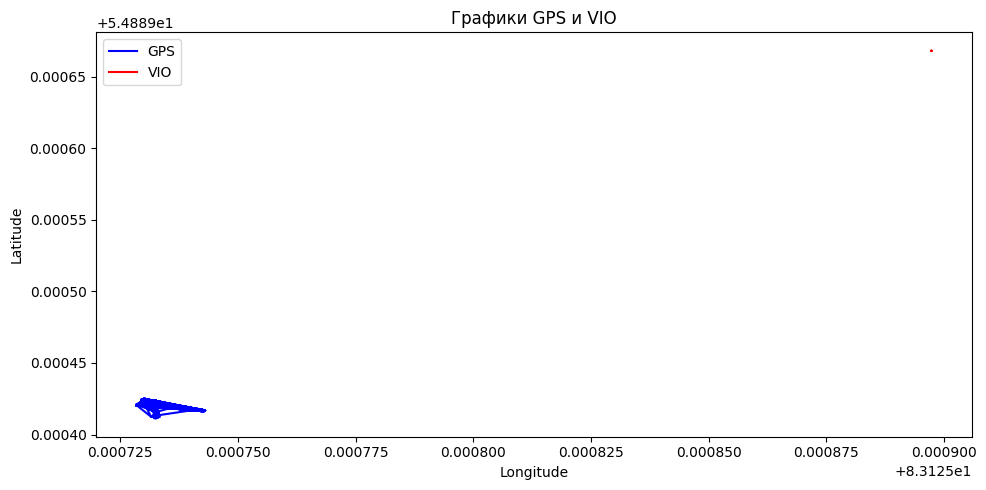

In [19]:
copy_lat_VIO = lat_VIO.copy()
copy_lon_VIO = lon_VIO.copy()

copy_lat_GPS = lat_GPS.copy()
copy_lon_GPS = lon_GPS.copy()

# Create figure and axis
# Создаем фигуру и оси
plt.figure(figsize=(10, 5))
# copy_lat_GPS = [ - x + 2 * 54.8894116667 for x in copy_lat_GPS]

# Рисуем первый график
plt.plot(copy_lon_GPS, copy_lat_GPS, label='GPS', color='blue')

# Рисуем второй график
plt.plot(copy_lon_VIO, copy_lat_VIO, label='VIO', color='red')

# Добавляем заголовок и метки осей
plt.title('Графики GPS и VIO')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Добавляем легенду
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()